In [53]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import random
import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [5]:
def findFiles(path): 
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters)


# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [6]:
all_categories

['Dutch',
 'Spanish',
 'Vietnamese',
 'Russian',
 'Greek',
 'English',
 'Czech',
 'Japanese',
 'Polish',
 'French',
 'German',
 'Portuguese',
 'Arabic',
 'Chinese',
 'Irish',
 'Korean',
 'Scottish',
 'Italian']

To represent a word we join a bunch of one hot vectors for chars  into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here

In [15]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

![](Z2xbySO.png)

In [87]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1) # concat on dimension 1 which makes the size = input_s + hidden_s
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)



In [88]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn.cuda()   # passing arguments to the gpu before we define te optimizer


RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

In [90]:
_input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
_input = _input.to('cuda')
hidden = hidden.to('cuda')

output, next_hidden = rnn(_input[0], hidden)
print(output)

tensor([[-2.8506, -2.9480, -2.8357, -2.7902, -2.9355, -2.9071, -2.8031,
         -2.8949, -2.8905, -2.8450, -2.8602, -2.9219, -2.9002, -2.8868,
         -2.8761, -2.9226, -2.9790, -3.0064]], device='cuda:0')


As you can see the output is a <1 x n_categories> Tensor, where every item is the likelihood of that category (higher is more likely).


In [91]:
def categoryFromOutput(output):
    # A tuple of (values, indices) is returned,
    # where the indices are the indices of the elements in the original input tensor.
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Russian', 3)


In [92]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Diep
category = Irish / line = Brian
category = Czech / line = Meszes
category = Greek / line = Maneates
category = Chinese / line = Luo
category = Greek / line = Karameros
category = Korean / line = Chweh
category = Chinese / line = Shen
category = Korean / line = Shim
category = Irish / line = Names


Each loop of training will:<br>

Create input and target tensors<br>
Create a zeroed initial hidden state<br>
Read each letter in and<br>
Keep hidden state for next letter<br>
Compare final output to target<br>
Back-propagate<br>
Return the output and loss<br>

### Train

In [50]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    category_tensor = category_tensor.to('cuda')
    line_tensor = line_tensor.to('cuda')
    for i in range(line_tensor.size()[0]):
        hidden = hidden.to('cuda')
        output, hidden = rnn(line_tensor[i], hidden)

    loss = nn.NLLLoss()(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [52]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output) # returns e.g ('Portuguese', 11)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 3.4911 Castillion / Russian ✗ (Spanish)
10000 10% (0m 20s) 0.5966 Horiatis / Greek ✓
15000 15% (0m 30s) 2.4426 Lestrange / Russian ✗ (French)
20000 20% (0m 41s) 2.2458 Cruz / Korean ✗ (Portuguese)
25000 25% (0m 51s) 2.0465 Kim / Korean ✗ (Vietnamese)
30000 30% (1m 1s) 1.5055 Neville / French ✗ (Irish)
35000 35% (1m 11s) 2.0243 Ghanem / Arabic ✓
40000 40% (1m 21s) 0.0912 Muzhkaterov / Russian ✓
45000 45% (1m 32s) 0.8008 an / Vietnamese ✓
50000 50% (1m 43s) 0.9004 Dobrushkin / Russian ✓
55000 55% (1m 54s) 0.8589 Vinh / Vietnamese ✓
60000 60% (2m 4s) 0.1328 Donovan / Irish ✓
65000 65% (2m 15s) 1.1506 Tian / Vietnamese ✗ (Chinese)
70000 70% (2m 27s) 0.7497 Shimuzu / Japanese ✓
75000 75% (2m 41s) 0.1680 Coelho / Portuguese ✓
80000 80% (2m 52s) 0.3722 Mathghamhain / Irish ✓
85000 85% (3m 2s) 2.4177 Noro / Portuguese ✗ (Japanese)
90000 90% (3m 13s) 1.3328 Rzehak / Czech ✓
95000 95% (3m 24s) 0.5049 Tovarovsky / Russian ✓
100000 100% (3m 36s) 1.6488 Salazar / Arabic ✗ (Portugue

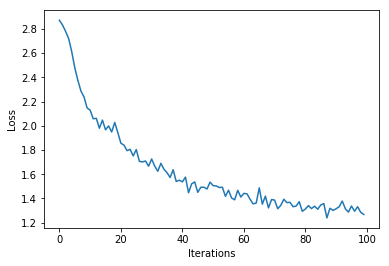

In [57]:
plt.figure()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show(plt.plot(all_losses))

### Evaluating the results with Confusion matrix

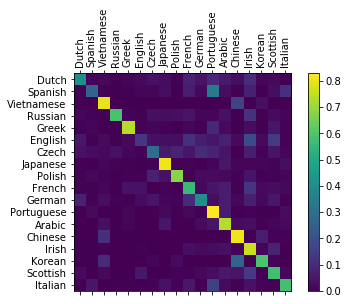

In [59]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    line_tensor = line_tensor.to('cuda')
    for i in range(line_tensor.size()[0]):
        hidden = hidden.to('cuda')
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

User prediction

In [61]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [69]:
predict("Yair")


> Yair
(-0.60) Korean
(-1.80) Chinese
(-2.29) German


Now we will try to improve this model by using LSTM